In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tqdm
import time
from PIL import Image
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

path = "/content/drive/My Drive/APS360 Project/v6-dataset/"

In [0]:
# These ae the classes we will be training in our model

classes = ["Apple",
           "Bagel",
           "Banana",
           "Bread",
           "Broccoli",
           "Burrito",
           "Carrot",
           "Cheese",
           "Coffee",
           "Cookie",
           "Cucumber",
           "Egg (Food)",
           "French fries",
           "Grape",
           "Hamburger",
           "Hot dog",
           "Juice",
           "Lemon",
           "Lobster",
           "Muffin",
           "Orange",
           "Pancake",
           "Pasta",
           "Pear",
           "Pizza",
           "Potato",
           "Salad",
           "Sandwich",
           "Strawberry",
           "Taco",
           "Tomato",
           "Waffle"]

classDict = {"Apple":0,
           "Bagel":1,
           "Banana":2,
           "Bread":3,
           "Broccoli":4,
           "Burrito":5,
           "Carrot":6,
           "Cheese":7,
           "Coffee":8,
           "Cookie":9,
           "Cucumber":10,
           "Egg (Food)":11,
           "French fries":12,
           "Grape":13,
           "Hamburger":14,
           "Hot dog":15,
           "Juice":16,
           "Lemon":17,
           "Lobster":18,
           "Muffin":19,
           "Orange":20,
           "Pancake":21,
           "Pasta":22,
           "Pear":23,
           "Pizza":24,
           "Potato":25,
           "Salad":26,
           "Sandwich":27,
           "Strawberry":28,
           "Taco":29,
           "Tomato":30,
           "Waffle":31}

In [0]:
def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

In [0]:
def dataloader(filePath='clean-train-id.csv', batch_size=8, normalize=True):
    # Load default width
    widthScale = 300
    
    # Load csv and shuffle
    headers = pd.read_csv(os.path.join(path, filePath))
    headers = headers.sample(frac=1)
    transform = transforms.ToTensor()
    if normalize:
        transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # Make tensor of images, (labels and bbox)
    for i in range(0, len(headers.filePath), batch_size):
        imgs, label = [], []
        
        for j in range(batch_size):
            # Old image
            if i+j >= len(headers.filePath):
                break

            imgOG = Image.open(headers.filePath[i+j]).convert('RGB')
            wpercent = (widthScale/float(imgOG.size[0]))
            hsize = int((float(imgOG.size[1])*wpercent))
            # display(imgOG)

            # New image
            img = imgOG.resize((widthScale, hsize), Image.ANTIALIAS)
            # display(img)
            w, h = img.size
            img = transform(img).cuda()
            imgs.append(img)

            # Add labels to the dictionary
            boxes_dict = {}
            boxes_dict['boxes'] = torch.tensor([[headers.XMin[i+j] * w, 
                                                 headers.YMin[i+j] * h, 
                                                 headers.XMax[i+j] * w, 
                                                 headers.YMax[i+j] * h]]).cuda()
            boxes_dict['labels'] = torch.tensor([classDict[headers.Class_Description[i+j]]]).cuda()

            label.append(boxes_dict)
        
        yield imgs, label

def sampleDataSet(filePath='clean-train-id.csv', batch_size=8, normalize=True):
    # Load default width
    widthScale = 250
    
    # Load csv and shuffle
    headers = pd.read_csv(os.path.join(path, filePath))
    headers = headers.sample(frac=1)
    length = int(0.05 * len(headers.filePath))
    print(f"LENGTH: {length}")
    transform = transforms.ToTensor()
    
    if normalize:
        transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    for i in range(0, length, batch_size):
        imgs, label = [], []

        for j in range(batch_size):
            if i+j >= length:
                break

            imgOG = Image.open(headers.filePath[i+j]).convert('RGB')
            wpercent = (widthScale/float(imgOG.size[0]))
            hsize = int((float(imgOG.size[1])*wpercent))

            # New image
            img = imgOG.resize((widthScale, hsize), Image.ANTIALIAS)
            w, h = img.size
            img = transform(img).cuda()
            imgs.append(img)

            # Add labels to the dictionary
            boxes_dict = {}
            boxes_dict['boxes'] = torch.tensor([[headers.XMin[i+j] * w, 
                                                 headers.YMin[i+j] * h, 
                                                 headers.XMax[i+j] * w, 
                                                 headers.YMax[i+j] * h]]).cuda()
            boxes_dict['labels'] = torch.tensor([classDict[headers.Class_Description[i+j]]]).cuda()

            label.append(boxes_dict)
        
        yield imgs, label

In [0]:
def get_model_accuracy(model, val=False, batch_size=6):
    s_losses = []
    tr_idx = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        if val:
            imported = dataloader(filePath='clean-validation-id.csv', batch_size=batch_size, normalize=True)
        else:
            imported = sampleDataSet(filePath='clean-train-id.csv', batch_size=batch_size, normalize=True)

        for img, box in imported:
            box_cp = box[0].copy()
            model = model.eval()

            if model(img)[0]['labels'].tolist()!=[]:
                predict = model(img)[0]
                find_idx = 0

                for each in range(predict['labels'].shape[0]):
                    if predict['labels'].tolist()[each]==box_cp['labels'].tolist()[0] and jaccard(predict['boxes'][each].unsqueeze(0),box_cp['boxes'][0].unsqueeze(0))>=0.4:
                        correct += 1
                        find_idx = each
                        break
                        
                out = predict['labels'][find_idx]
                resize_box = np.array(predict['boxes'][find_idx].tolist())

            total += 1

            # if val:
            #     print (('\tProcessing iteration {} | Validation Acc: {}\n').format(tr_idx, correct/total))

            # else:
            #     print (('\tProcessing iteration {} | Training Acc: {}\n').format(tr_idx, correct/total))
            tr_idx += 1
    
    return correct/total

def get_model_loss(val_model, val=False, batch_size=6):
    s_losses = []
    val_idx = 0

    with torch.no_grad():
        val_model = val_model.train()    
        if val:
            imported = dataloader(filePath='clean-validation-id.csv', batch_size=batch_size, normalize=True)
        else:
            imported = sampleDataSet(filePath='clean-train-id.csv', batch_size=batch_size, normalize=True)
        
        for img, box in imported:
            box_cp = box[0].copy()
            loss_dict = val_model(img,box)
            losses = sum(loss for loss in loss_dict.values())
            s_losses.append(losses/batch_size)
            del loss_dict
            val_model = val_model.eval()

    return sum(s_losses)/len(s_losses)

In [0]:
filePath = os.path.join(path, 'rcnn-test-images')
print(filePath)

In [0]:
filePath = os.path.join(path, 'rcnn-test-images')
print(filePath)

test_data = torchvision.datasets.ImageFolder(filePath,
                                             loader=plt.imread,
                                             transform=transforms.ToTensor())

test_data

In [0]:
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 200),),aspect_ratios=((0.5, 1.0, 2.0),))
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],output_size=7,sampling_ratio=2)
rcnn1 = FasterRCNN(backbone,num_classes=32,rpn_anchor_generator=anchor_generator,box_roi_pool=roi_pooler).cuda()

In [0]:
training_acc = [0.10727969348659004,
                0.2950191570881226,
                0.2567049808429119,
                0.41762452107279696,
                0.4367816091954023,
                0.5440613026819924,
                0.6015325670498084,
                0.4904214559386973,
                0.5517241379310345,
                0.5708812260536399,
                0.6819923371647509,
                0.6934865900383141,
                0.7049808429118773,
                0.6973180076628352,
                0.7394636015325671,
                0.7279693486590039,
                0.7471264367816092,
                0.7279693486590039,
                0.7471264367816092,
                0.7509578544061303,
                0.7701149425287356,
                0.7969348659003831,
                0.7777777777777778,
                0.7816091954022989,
                0.7969348659003831,
                0.8045977011494253,
                0.7432950191570882,
                0.7931034482758621,
                0.7739463601532567,
                0.8122605363984674,
                0.8045977011494253,
                0.735632183908046
                ]

validation_acc = [0.18518518518518517,
                  0.4,
                  0.37777777777777777,
                  0.4703703703703704,
                  0.4777777777777778,
                  0.6074074074074074,
                  0.6111111111111112,
                  0.5555555555555556,
                  0.5518518518518518,
                  0.6,
                  0.674074074074074,
                  0.7037037037037037,
                  0.7037037037037037,
                  0.6666666666666666,
                  0.6962962962962963,
                  0.6925925925925925,
                  0.7,
                  0.6703703703703704,
                  0.6851851851851852,
                  0.6888888888888889,
                  0.6851851851851852,
                  0.7,
                  0.7074074074074074,
                  0.7222222222222222,
                  0.6925925925925925,
                  0.7111111111111111,
                  0.6962962962962963,
                  0.6888888888888889,
                  0.7037037037037037,
                  0.6592592592592592,
                  0.7,
                  0.6925925925925925,
                  0.674074074074074
                  ]

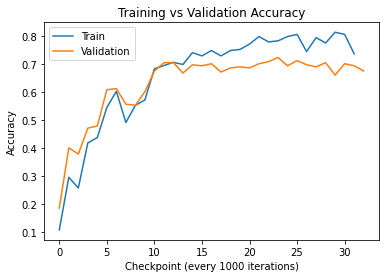

In [0]:
plt.title("Training vs Validation Accuracy")
plt.plot(range(len(training_acc)), training_acc, label="Train")
plt.plot(range(len(validation_acc)), validation_acc, label='Validation')
plt.xlabel("Checkpoint (every 1000 iterations)")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()


In [0]:
img_show = []
height = []
width = []
for i in range(len(test_data)):
    img_show.append(plt.imread(test_data.imgs[i][0]))
    height.append(img_show[-1].shape[0])
    width.append(img_show[-1].shape[1])

In [0]:
result = []
with torch.no_grad():
    for i in range(len(test_data)):
        result.append(rcnn1([test_data[i][0].cuda()]))

In [0]:
for i in range(len(test_data)):
    first_box = result[i][0]['boxes'][0].unsqueeze(0)
    box_id = 0
    plt.cla()
    plt.imshow(img_show[i])

    overlap = 0.8
    confidence = 0.3
    for box in result[i][0]['boxes']:
        if (box_id==0 or jaccard(first_box,box.unsqueeze(0)).tolist()[0][0]<overlap):
            if result[i][0]['scores'].tolist()[box_id]>=confidence:
                x1 = int(box[0])
                y1 = int(box[1])
                x2 = int(box[2])
                y2 = int(box[3])
                #check other boxes
                flag = True
                for each in range(result[i][0]['boxes'].shape[0]):
                    if each!=box_id and result[i][0]['scores'].tolist()[each]>=confidence and jaccard(first_box,result[i][0]['boxes'][each].unsqueeze(0)).tolist()[0][0]<overlap:
                            o_x1 = int(result[i][0]['boxes'][each][0])
                            o_y1 = int(result[i][0]['boxes'][each][1])
                            o_x2 = int(result[i][0]['boxes'][each][2])
                            o_y2 = int(result[i][0]['boxes'][each][3])
                            if x1>=o_x1-3 and y1>=o_y1-3 and x2<=o_x2+3 and y2<=o_y2+3 and result[i][0]['labels'][box_id]==result[i][0]['labels'][each]:
                                flag = False
                                break
                                
                if flag:
                    plt.gca().add_patch(plt.Rectangle((x1, y1),x2 - x1,y2 - y1, fill=False, edgecolor='b',linewidth=3))
                    plt.text(x1,y1,classes[result[i][0]['labels'][box_id]], color='blue',fontsize=12,weight='bold')
        box_id += 1
    plt.show() 